# Assignment 25

In [1]:
import os

import tensorflow as tf
from tensorflow import keras



In [0]:
# import keras
# from keras.datasets import cifar10
# from keras.models import Model, Sequential
# from keras.layers import Dense, Dropout, Flatten, Input, AveragePooling2D, merge, Activation
# from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
# from keras.layers import Concatenate
# from keras.optimizers import Adam
from tensorflow.keras import models, layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Activation, Flatten
from tensorflow.keras.optimizers import Adam

In [0]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 10
l = 40
num_filter = 12
compression = 0.5
dropout_rate = 0.2

#### Loading data

In [4]:
# Load CIFAR10 Data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
img_height, img_width, channel = X_train.shape[1],X_train.shape[2],X_train.shape[3]

# convert to one hot encoing 
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes) 

170500096/170498071 [==============================] - 13s 0us/step


In [5]:
X_train.shape

(50000, 32, 32, 3)

#### Standarding data

In [0]:
def prep_pixels(train, test):
# convert from integers to floats
    train_norm = train.astype('float32')
    test_norm = test.astype('float32')
# normalize to range 0-1
    train_norm = train_norm / 255.0
    test_norm = test_norm / 255.0
# return normalized images
    return train_norm, test_norm

In [0]:


X_train,X_test=prep_pixels(X_train,X_test)

Using TensorFlow backend.


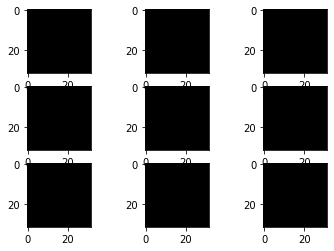

In [8]:
#https://machinelearningmastery.com/how-to-configure-image-data-augmentation-when-training-deep-learning-neural-networks/
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
c=X_train[1]
c.shape
samples = expand_dims(c, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=90)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    pyplot.subplot(330 + 1 + i)
# generate batch of images
    batch = it.next()
# convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
# plot raw pixel data
    pyplot.imshow(image)
# show the figure

pyplot.show()

In [0]:
# Defining the model

 ### Model using dense layer

In [0]:
# Dense Block
def denseblock(input, num_filter = 64, dropout_rate = 0):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (5,5),kernel_initializer="he_uniform" ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 32, dropout_rate = 0):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), kernel_initializer="he_uniform" ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers.AveragePooling2D(pool_size=(2,2))(relu)
    flat = layers.Flatten()(AvgPooling)
    output = layers.Dense(num_classes, activation='softmax')(flat)
    return output



In [0]:
num_filter = 10
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(num_filter, (5,5), use_bias=False ,padding='same')(input)
BatchNorm = layers.BatchNormalization()(First_Conv2D)

First_Block = denseblock(BatchNorm,32, dropout_rate)
First_Transition = transition(First_Block, num_filter, dropout_rate)

Second_Block = denseblock(First_Transition, 16, dropout_rate)
Second_Transition = transition(Second_Block, num_filter, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, num_filter, dropout_rate)
conv_layer = layers.Conv2D(num_filter, (1,1), use_bias=False ,padding='same') (input)
last = layers.GlobalMaxPooling2D()(conv_layer)
output = layers.Activation('softmax')(last)


In [19]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 32, 32, 10)        30        
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 10)                0         
_________________________________________________________________
activation_208 (Activation)  (None, 10)                0         
Total params: 30
Trainable params: 30
Non-trainable params: 0
_________________________________________________________________


In [0]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(), metrics=['accuracy'])



Epoch 1/15
781/781 [==============================] - 22s 28ms/step - loss: 2.3086 - acc: 0.1021 - val_loss: 2.2968 - val_acc: 0.1032
Epoch 2/15
781/781 [==============================] - 19s 24ms/step - loss: 2.2958 - acc: 0.1091 - val_loss: 2.2929 - val_acc: 0.1346
Epoch 3/15
781/781 [==============================] - 19s 24ms/step - loss: 2.2923 - acc: 0.1288 - val_loss: 2.2896 - val_acc: 0.1378
Epoch 4/15
781/781 [==============================] - 19s 24ms/step - loss: 2.2891 - acc: 0.1359 - val_loss: 2.2862 - val_acc: 0.1553
Epoch 5/15
781/781 [==============================] - 19s 25ms/step - loss: 2.2857 - acc: 0.1445 - val_loss: 2.2830 - val_acc: 0.1320
Epoch 6/15
781/781 [==============================] - 19s 24ms/step - loss: 2.2825 - acc: 0.1472 - val_loss: 2.2792 - val_acc: 0.1554
Epoch 7/15
781/781 [==============================] - 19s 24ms/step - loss: 2.2789 - acc: 0.1502 - val_loss: 2.2754 - val_acc: 0.1560
Epoch 8/15
781/781 [==============================] - 19s 24ms

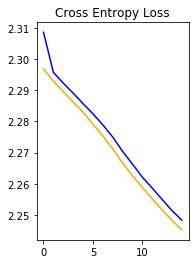

In [21]:
#https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-cifar-10-photo-classification/
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=64)
	# fit model
	steps = int(X_train.shape[0] / 64)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=15, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness
run_test_harness()

train_loss: 0.1203   train_acc: 0.9561 

val_loss: 0.6271   val_acc: 0.8439

### Model without dense layer

In [0]:
from keras import regularizers
# Dense Block
def denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l): 
        BatchNorm = layers.BatchNormalization()(temp)
        relu = layers.Activation('relu')(BatchNorm)
        Conv2D_3_3 = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
        if dropout_rate>0:
            Conv2D_3_3 = layers.Dropout(dropout_rate)(Conv2D_3_3)
        concat = layers.Concatenate(axis=-1)([temp,Conv2D_3_3])
        
        temp = concat
        
    return temp

## transition Blosck
def transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    Conv2D_BottleNeck = layers.Conv2D(int(num_filter*compression), (5,5), use_bias=False ,padding='same')(relu)
    if dropout_rate>0:
         Conv2D_BottleNeck = layers.Dropout(dropout_rate)(Conv2D_BottleNeck)
    avg = layers.AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    return avg

#output layer
def output_layer(input):
    global compression
    BatchNorm = layers.BatchNormalization()(input)
    relu = layers.Activation('relu')(BatchNorm)
    AvgPooling = layers. MaxPooling2D(pool_size=(2,2))(relu)
    
    output = layers.Conv2D(filters=10,kernel_size=(2,2),activation='softmax')(AvgPooling)
   
    flat = layers.Flatten()(output)    
    return flat



num_filter = 12
dropout_rate = 0
l = 12
input = layers.Input(shape=(img_height, img_width, channel,))
First_Conv2D = layers.Conv2D(32, (3,3), use_bias=False ,padding='same')(input)

First_Block = denseblock(First_Conv2D,10, dropout_rate)
First_Transition = transition(First_Block, 64, dropout_rate)

Second_Block = denseblock(First_Transition, 10, dropout_rate)
Second_Transition = transition(Second_Block, 32, dropout_rate)

Third_Block = denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = transition(Third_Block, 32, dropout_rate)

conv_layer = layers.Conv2D(num_filter, (1,1), use_bias=False ,padding='same')(input)
last = layers.GlobalMaxPooling2D()(conv_layer)
output = layers.Activation('softmax')(last)


In [23]:
model = Model(inputs=[input], outputs=[output])
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_256 (Conv2D)          (None, 32, 32, 12)        36        
_________________________________________________________________
global_max_pooling2d_2 (Glob (None, 12)                0         
_________________________________________________________________
activation_248 (Activation)  (None, 12)                0         
Total params: 36
Trainable params: 36
Non-trainable params: 0
_________________________________________________________________


In [0]:
# determine Loss function and Optimizer
#a=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(loss='categorical_crossentropy',
              optimizer='Adam', metrics=['accuracy'])


In [0]:
def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=60)
	# fit model
	steps = int(X_train.shape[0] / 39)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=20, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness


In [0]:
from keras.models import load_model
#saving model weights 
model.save('my_model.h5') 

 ###### JUST CONTINUING THE MODEL FOR ANOTHER 5 EPOCHS 

In [0]:

def summarize_diagnostics(history):
	# plot loss
	pyplot.subplot(121)
	pyplot.title('Cross Entropy Loss')
	pyplot.plot(history.history['loss'], color='blue', label='train')
	pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.show()
	
 
# run the test harness for evaluating a model
def run_test_harness():
	
	# define model
	
	# create data generator
	datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
	# prepare iterator
	it_train = datagen.flow(X_train, y_train, batch_size=60)
	# fit model
	steps = int(X_train.shape[0] / 39)
	history = model.fit_generator(it_train, steps_per_epoch=steps, epochs=5, validation_data=(X_test, y_test), verbose=1)
	# evaluate model
	_, acc = model.evaluate(X_test, y_test, verbose=0)
	print('> %.3f' % (acc * 100.0))
	# learning curves
	summarize_diagnostics(history)
 
# entry point, run the test harness


train_loss: 0.0350               train_acc: 0.9877 
        
val_loss: 0.5632       val_acc: 0.8954

In [31]:
from prettytable import PrettyTable

conclusion= PrettyTable()
conclusion.field_names = [ "Model", 'epochs','train_loss','train acc',"test loss",'test acc']

conclusion.add_row(["model with dense layer", 75,0.1203, 0.956, 0.6271,0.843])
conclusion.add_row(["model without dense layer",205, 0.035, 0.987,0.563,0.895])


print(conclusion)

+---------------------------+--------+------------+-----------+-----------+----------+
|           Model           | epochs | train_loss | train acc | test loss | test acc |
+---------------------------+--------+------------+-----------+-----------+----------+
|   model with dense layer  |   75   |   0.1203   |   0.956   |   0.6271  |  0.843   |
| model without dense layer |  205   |   0.035    |   0.987   |   0.563   |  0.895   |
+---------------------------+--------+------------+-----------+-----------+----------+


# Conclusion 

> Overfitting is one the problem in this assignment since dropouts was excluded.

> Even tried using L2 regularization but still models are overfitting.

> Loss on test data doesnot change after certain number of iterations which can be seen from plots.

